In [1]:
# -----------------------------------------------------------------------------
# import packages
# -----------------------------------------------------------------------------
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn


import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform
import math

from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.flatten = lambda x: x.view(x.size(0), -1)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        
        return x


In [3]:
# -----------------------------------------------------------------------------
# load dataset
# -----------------------------------------------------------------------------
torch.manual_seed(70)
BATCH = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
STEP = 10

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


train_data_path = '../horse-or-human/train'
set_train = datasets.ImageFolder(root=train_data_path, transform=transform)
loader_train = torch.utils.data.DataLoader(set_train, batch_size=BATCH, shuffle=True)  


validation_data_path = '../horse-or-human/validation'
set_test = datasets.ImageFolder(root=validation_data_path, transform=transform)
loader_test = torch.utils.data.DataLoader(set_test, batch_size=BATCH, shuffle=True) 


In [5]:
def train(model, train_loader, loss_func, optimizer, step, device):
    
    loss_train = []
    correct = 0
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #경사 초기화
        model.zero_grad()
        #순방향전파
        output = model(data)
        # 손실값 계산
        loss = loss_func(output, target)
        # 역방향 전파
        loss.backward()
        # 매개변수 업데이트
        optimizer.step()
        
        loss_train_batch    = loss.item() / len(data)
        loss_train.append(loss_train_batch)
        
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_train_mean = np.mean(loss_train)
    loss_train_std = np.std(loss_train)
    accuracy_train   = 100. * float(correct) / len(train_loader.dataset)
    
    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 'accuracy_train': accuracy_train}

def test(model, test_loader, loss_func, device):

    accuracy_test   = []

    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # forward pass
            output = model(data)
            # calculate loss(sum)
            test_loss += loss_func(output, target, reduction="sum").item()
            
            pred = output.data.max(1)[1]
            
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    test_loss /= len(test_loader.dataset)
    accuracy_test   = 100. * float(correct) / len(test_loader.dataset)

    
    return {'loss_test': test_loss, 'accuracy_test': accuracy_test}



In [7]:
def main(model, train_loader, test_loader, loss_func, optimizer, n_step,
        device):
    """main function"""
    loss_train_mean = []
    loss_train_std = []
    loss_test = []
    accuracy_test = []
    accuracy_train = []
    correct = 0
    
    for step in range(1, n_step+1):
        # train
        result_train = train(model, train_loader, loss_func, optimizer,
             step=step, device=device)
        # validation
        result_test = test(model, test_loader,
                                  loss_func=F.cross_entropy,
                                  device=device)
        
        loss_train_mean.append(result_train['loss_train_mean'])
        loss_train_std.append(result_train['loss_train_std'])
        loss_test.append(result_test['loss_test'])
        accuracy_test.append(result_test['accuracy_test'])
        accuracy_train.append(result_train['accuracy_train'])
        
        print("[epoch {:05}] loss:(training){:01.10f} ,(testing){:01.10f}, accuracy:(training){:03.10f}, (testing){:03.10f}".format(
        step, loss_train_mean[step-1], loss_test[step-1], accuracy_train[step-1],accuracy_test[step-1] ))
    
    plt.plot(np.squeeze(accuracy_train), label='train set')
    plt.plot(np.squeeze(accuracy_test), label='validation')
    plt.ylabel('accuracy')
    plt.xlabel('iterations ')
    plt.legend()
    plt.show()
    
    plt.plot(np.squeeze(loss_train_mean), label='loss train')
    plt.plot(np.squeeze(loss_test), label='loss test')
    plt.ylabel('loss')
    plt.xlabel('iterations ')
    plt.legend()
    plt.show()
    
    t = np.arange(n_step)
    fig, ax = plt.subplots(1)
    mu1 = np.squeeze(loss_train_mean)
    sigma1 = np.squeeze(loss_train_std)
    ax.plot(t, mu1, lw=2, label='mean population 1', color='blue')
    ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
    ax.set_title("std mean")
    ax.set_xlabel('num steps')
    ax.set_ylabel('loss')
    ax.grid()


In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

[epoch 00001] loss:(training)0.0639402416 ,(testing)0.3175081671, accuracy:(training)63.8753651412, (testing)86.7187500000
[epoch 00002] loss:(training)0.0469270926 ,(testing)0.3110582279, accuracy:(training)77.5073028238, (testing)86.3281250000
[epoch 00003] loss:(training)0.0436189250 ,(testing)0.2866082140, accuracy:(training)79.3573515093, (testing)87.1093750000
[epoch 00004] loss:(training)0.0332843885 ,(testing)0.6759933913, accuracy:(training)86.2706913340, (testing)72.6562500000
[epoch 00005] loss:(training)0.0364793713 ,(testing)0.3096818298, accuracy:(training)84.5180136319, (testing)87.8906250000
[epoch 00006] loss:(training)0.0295534247 ,(testing)0.8014627693, accuracy:(training)86.8549172347, (testing)73.8281250000
[epoch 00007] loss:(training)0.0300271521 ,(testing)0.3665246028, accuracy:(training)88.0233690360, (testing)88.2812500000
[epoch 00008] loss:(training)0.0255068916 ,(testing)0.3952480375, accuracy:(training)89.8734177215, (testing)85.9375000000
[epoch 00009] lo

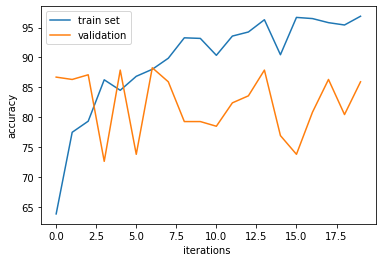

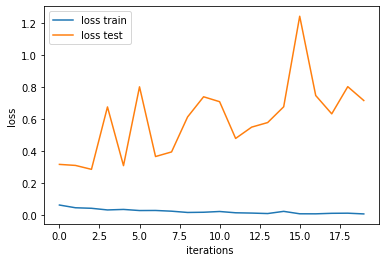

In [10]:
BATCH = 10
STEP = 20

loader_train = torch.utils.data.DataLoader(set_train, batch_size=BATCH, shuffle=True)  
loader_test = torch.utils.data.DataLoader(set_test, batch_size=BATCH, shuffle=True)  
model = Net(input_size=100*100, hidden_size=100, output_size=2).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
main(model=model,
    train_loader=loader_train,
    test_loader = loader_test,
    loss_func=loss_function,
    optimizer=optimizer,
    n_step=STEP,
    device=DEVICE)

[epoch 00001] loss:(training)0.0642595982 ,(testing)0.3157074656, accuracy:(training)63.8753651412, (testing)87.5000000000
[epoch 00002] loss:(training)0.0508502570 ,(testing)0.4996925849, accuracy:(training)72.1518987342, (testing)78.5156250000
[epoch 00003] loss:(training)0.0453587075 ,(testing)0.4130084747, accuracy:(training)77.3125608569, (testing)82.0312500000
[epoch 00004] loss:(training)0.0387384106 ,(testing)0.3978937576, accuracy:(training)81.8889970789, (testing)81.2500000000
[epoch 00005] loss:(training)0.0395727556 ,(testing)0.8045758163, accuracy:(training)80.8179162610, (testing)76.5625000000
[epoch 00006] loss:(training)0.0315677487 ,(testing)0.6614011785, accuracy:(training)85.7838364167, (testing)75.0000000000
[epoch 00007] loss:(training)0.0300473633 ,(testing)0.3939689933, accuracy:(training)86.6601752678, (testing)87.8906250000
[epoch 00008] loss:(training)0.0246476210 ,(testing)0.9012101679, accuracy:(training)89.9707887050, (testing)75.0000000000
[epoch 00009] lo

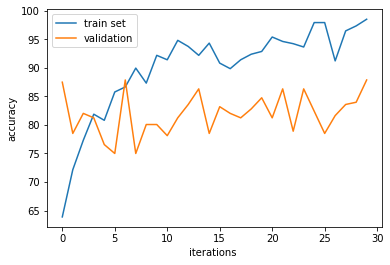

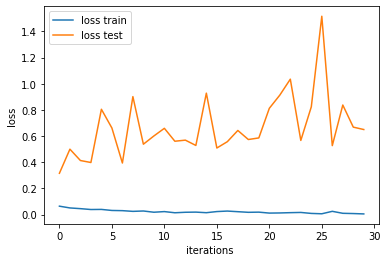

In [11]:
BATCH = 10
STEP = 30

loader_train = torch.utils.data.DataLoader(set_train, batch_size=BATCH, shuffle=True)  
loader_test = torch.utils.data.DataLoader(set_test, batch_size=BATCH, shuffle=True)  
model = Net(input_size=100*100, hidden_size=100, output_size=2).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
main(model=model,
    train_loader=loader_train,
    test_loader = loader_test,
    loss_func=loss_function,
    optimizer=optimizer,
    n_step=STEP,
    device=DEVICE)

[epoch 00001] loss:(training)0.0694779095 ,(testing)0.6092569763, accuracy:(training)59.3962999026, (testing)63.2812500000
[epoch 00002] loss:(training)0.0525189726 ,(testing)0.3155479555, accuracy:(training)72.8334956183, (testing)88.2812500000
[epoch 00003] loss:(training)0.0462497292 ,(testing)0.5369229533, accuracy:(training)77.4099318403, (testing)74.6093750000
[epoch 00004] loss:(training)0.0395191996 ,(testing)0.3049828629, accuracy:(training)81.4021421616, (testing)87.5000000000
[epoch 00005] loss:(training)0.0380364462 ,(testing)0.4413219406, accuracy:(training)82.3758519961, (testing)78.9062500000
[epoch 00006] loss:(training)0.0328633290 ,(testing)0.8661352270, accuracy:(training)85.0048685492, (testing)74.2187500000
[epoch 00007] loss:(training)0.0343877871 ,(testing)0.3773404330, accuracy:(training)83.0574488802, (testing)84.3750000000
[epoch 00008] loss:(training)0.0335702929 ,(testing)0.3793487165, accuracy:(training)84.3232716650, (testing)88.2812500000
[epoch 00009] lo

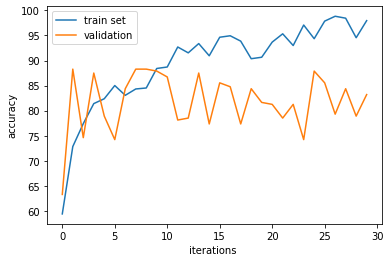

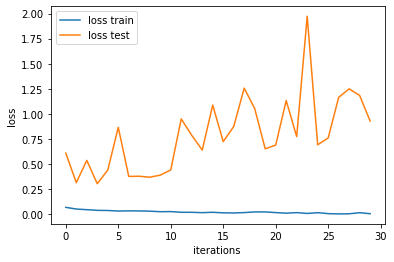

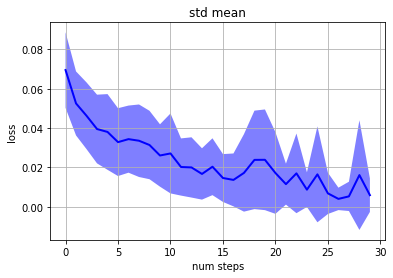

In [8]:
BATCH = 10
STEP = 30

loader_train = torch.utils.data.DataLoader(set_train, batch_size=BATCH, shuffle=True)  
loader_test = torch.utils.data.DataLoader(set_test, batch_size=BATCH, shuffle=True)  
model = Net(input_size=100*100, hidden_size=100, output_size=2).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
main(model=model,
    train_loader=loader_train,
    test_loader = loader_test,
    loss_func=loss_function,
    optimizer=optimizer,
    n_step=STEP,
    device=DEVICE)

[epoch 00001] loss:(training)0.0349112514 ,(testing)0.4335389528, accuracy:(training)59.2989289192, (testing)85.5468750000
[epoch 00002] loss:(training)0.0281824894 ,(testing)0.3266655058, accuracy:(training)72.3466407011, (testing)88.2812500000
[epoch 00003] loss:(training)0.0247596710 ,(testing)0.7559450641, accuracy:(training)75.7546251217, (testing)61.3281250000
[epoch 00004] loss:(training)0.0202911197 ,(testing)0.3636490563, accuracy:(training)81.5968841285, (testing)82.4218750000
[epoch 00005] loss:(training)0.0182750013 ,(testing)0.8257955238, accuracy:(training)83.9337877313, (testing)70.7031250000
[epoch 00006] loss:(training)0.0146300913 ,(testing)0.6154090734, accuracy:(training)87.0496592016, (testing)75.7812500000
[epoch 00007] loss:(training)0.0174842434 ,(testing)0.4272063794, accuracy:(training)85.7838364167, (testing)80.0781250000
[epoch 00008] loss:(training)0.0130528802 ,(testing)1.1985148340, accuracy:(training)90.5550146056, (testing)70.7031250000
[epoch 00009] lo

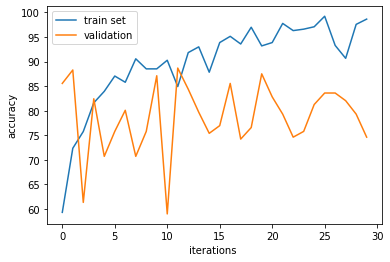

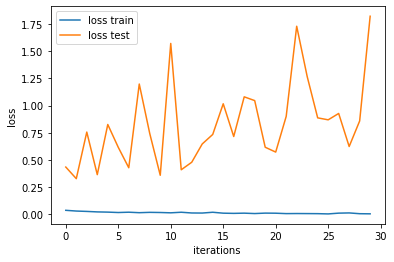

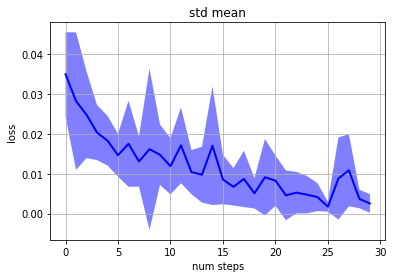

In [9]:
BATCH = 20
STEP = 30

loader_train = torch.utils.data.DataLoader(set_train, batch_size=BATCH, shuffle=True)  
loader_test = torch.utils.data.DataLoader(set_test, batch_size=BATCH, shuffle=True)  
model = Net(input_size=100*100, hidden_size=100, output_size=2).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
main(model=model,
    train_loader=loader_train,
    test_loader = loader_test,
    loss_func=loss_function,
    optimizer=optimizer,
    n_step=STEP,
    device=DEVICE)

[epoch 00001] loss:(training)0.1360117231 ,(testing)0.4083604508, accuracy:(training)58.6173320351, (testing)86.7187500000
[epoch 00002] loss:(training)0.1070081758 ,(testing)0.3661375765, accuracy:(training)72.7361246349, (testing)87.1093750000
[epoch 00003] loss:(training)0.0828012731 ,(testing)0.2687010550, accuracy:(training)79.9415774099, (testing)90.2343750000
[epoch 00004] loss:(training)0.0859938911 ,(testing)0.5875548404, accuracy:(training)78.8704965920, (testing)75.7812500000
[epoch 00005] loss:(training)0.0690881638 ,(testing)0.3393695849, accuracy:(training)83.9337877313, (testing)89.8437500000
[epoch 00006] loss:(training)0.0900793545 ,(testing)1.2906746953, accuracy:(training)73.9045764362, (testing)58.9843750000
[epoch 00007] loss:(training)0.0765698632 ,(testing)2.0366922575, accuracy:(training)82.3758519961, (testing)55.4687500000
[epoch 00008] loss:(training)0.0701369658 ,(testing)0.3325037058, accuracy:(training)82.9600778968, (testing)85.1562500000
[epoch 00009] lo

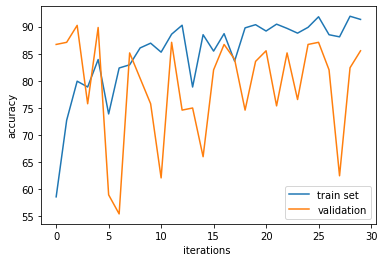

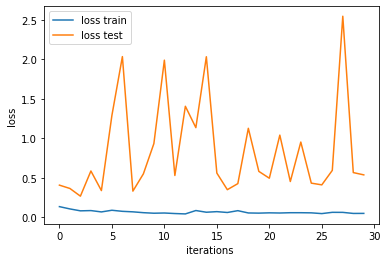

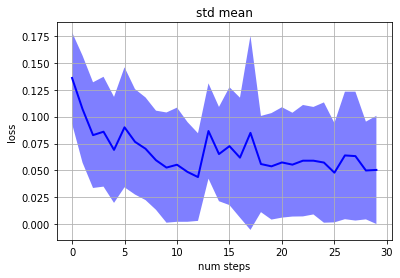

In [10]:
BATCH = 5
STEP = 30

loader_train = torch.utils.data.DataLoader(set_train, batch_size=BATCH, shuffle=True)  
loader_test = torch.utils.data.DataLoader(set_test, batch_size=BATCH, shuffle=True)  
model = Net(input_size=100*100, hidden_size=100, output_size=2).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
main(model=model,
    train_loader=loader_train,
    test_loader = loader_test,
    loss_func=loss_function,
    optimizer=optimizer,
    n_step=STEP,
    device=DEVICE)

[epoch 00001] loss:(training)0.0319191356 ,(testing)0.6827673968, accuracy:(training)64.1674780915, (testing)65.6250000000
[epoch 00002] loss:(training)0.0281880521 ,(testing)0.2828686647, accuracy:(training)70.3018500487, (testing)87.5000000000
[epoch 00003] loss:(training)0.0246338073 ,(testing)0.4158691671, accuracy:(training)76.3388510224, (testing)84.3750000000
[epoch 00004] loss:(training)0.0205933640 ,(testing)0.2888010144, accuracy:(training)81.7916260954, (testing)89.0625000000
[epoch 00005] loss:(training)0.0186873221 ,(testing)0.4898529295, accuracy:(training)83.1548198637, (testing)76.9531250000
[epoch 00006] loss:(training)0.0178124803 ,(testing)0.3401637953, accuracy:(training)83.8364167478, (testing)83.5937500000
[epoch 00007] loss:(training)0.0158272650 ,(testing)0.7600497175, accuracy:(training)86.1733203505, (testing)75.3906250000
[epoch 00008] loss:(training)0.0184470735 ,(testing)0.9475421757, accuracy:(training)84.6153846154, (testing)58.2031250000
[epoch 00009] lo

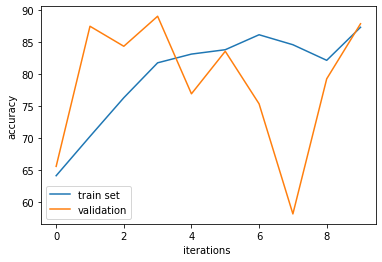

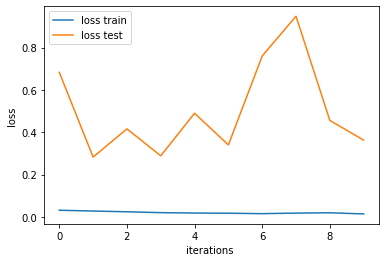

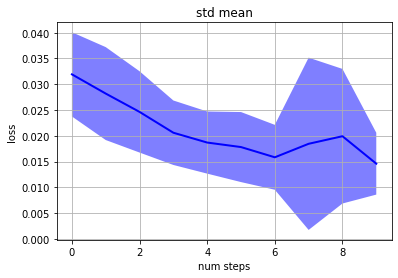

In [11]:
BATCH = 20
STEP = 10

loader_train = torch.utils.data.DataLoader(set_train, batch_size=BATCH, shuffle=True)  
loader_test = torch.utils.data.DataLoader(set_test, batch_size=BATCH, shuffle=True)  
model = Net(input_size=100*100, hidden_size=100, output_size=2).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
main(model=model,
    train_loader=loader_train,
    test_loader = loader_test,
    loss_func=loss_function,
    optimizer=optimizer,
    n_step=STEP,
    device=DEVICE)

## 3-nn model best accuracy(with pytorch)


| dataset | loss | accuracy | 
|:-------|-------:|:------:|
|   training    |0.0145884007|87.3417721519|
|   validation    |0.3628350599|87.8906250000|